# CS 4641 Final Project - ICE or Regional Bahn Classifier

Please consult the following overleaf for the write-up (text reproduced below):

Overleaf: https://www.overleaf.com/read/hksgpfxfbkzm

Data sources (footnotes):
1. Available at: https://www.dropbox.com/sh/lof27s03kpt1hjr/AAA8HAef6hYb41FVQnMvffBEa?dl=0
2. Available at: https://sr.ht/~nytpu/commons-downloader/
3. Available at: https://commons.wikimedia.org/wiki/Category:ICE


Group Members:
- Jonathan Zhou, jzhou460
- Matthew Zhou, mzhou314

## Introduction 
German rail service is primarily served by the state-owned private company Deutsche Bahn (DB). DB
operates numerous passenger rail services which can generally be two tiers of rail service: (1) regional
rail service (operated by DB Regio) and long distance service (operated by DB Fernverkehr). Regional
rail service also includes S-Bahn (hybrid urban-suburban rail systems), Regional Trains, and Regional
Express services(1).
Different kinds of rolling stock are operated by these two branches. In the flagship service of DB
Fernverkehr, the InterCity Express (ICE), special aerodynamic electric-multiple-units from Siemens
Mobility are used, and are painted in a white livery with a red stripe. On the other hand, regional train-sets,
typically manufactured by Bombardier or Siemens Mobility, can vary by region and by service, can be
both locomotive pulled or electric multiple units. Although they are more diverse in appearance, regional
trains are most often painted in a red livery, and we limit our analysis to this category for the sake of
simplicity.
We propose a model which given an image of an ICE or Regional trainset, gives a classification
between the two. Our model is based on top of Deep Residual Learning for Image Recognition (ResNET)
(3). We then perform transfer learning using with our ICE and Regional image samples( 4). We also use
image augmentation to increase the robustness of our training process ( 5). We implement our model using
the PyTorch software library.
A particular interesting application of our model is that regional rail tickets (e.g. the Nine Euro Ticket)
are not valid for long distance rail transport, so this model can be used to determine the validity of your
ticket for travel on a given trainset/service. This project could also be used to identify which trains are
currently running on the tracks and verify the location of their train. This would help prevent accidents
and serve as an additional level of verification for each train’s location

## DATA
In total we sourced (n = 815 ) images of ICE trainsets and (n = 622 ) images of Regional trainsets operating
across Germany and neighboring countries in .jpg format1. Representative images are provided in
Figure 1. We limited our samples to those depicting a singular trainset in primary focus (may be other
objects/trainsets in the background, but not the focus of the image) and where the trainset is clearly visible
in the image. While we allowed all variations of ICE trainset, we limited our analysis to only Regional
Trains painted in the most common red livery.
### Data Acquisition
To avoid watermarks and image rights issues, we pulled all of our images from Wikimedia Commons,
where all images were licensed under a Creative Commons License. We used a shell script to pull images
off of Wikimedia Commons, using different queries for the two data classes.2. The shell script allows us
to pull images in a given category and pull all images related to a given search query matching certain
tags and keywords using the Media Wiki search engine.
#### InterCity Express 
For the ICE we pulled images from select predetermined and precurated subcategories
(particularly those aggregating images of certain trainset models) of the ICE main topic page on Wikimedia
Commons with large amounts of exterior images of ICE trainsets.3
#### Regional Bahn 
We downloaded all images using the "S-Bahn" and "DB Regio" in bulk using
queries to the Wikimedia search engine.
Finally, after making these queries and pulling the data, we then manually rejected all images which
did not contain the trainsets as the primary subject of the image (including images of train interiors,
supporting infrastructure, or signage). We also rejected trains painted in unusual livery such as non-red
Regional Trains and special edition InterCity and EuroCity trains or trains visibly involved in maintenance
or disasters.
### Data Preprocessing
Data Augmentation To increase robustness of our training process we introduce image augmentation
into our training process. For the training set, we first resized the image to 281 × 281. Then, we randomly
cropped the images to be 256 × 256 . We then applied random rotations of up to±30 degrees and randomly
flipped the image horizontally. We finally normalized the image based on the mean and standard deviation
of ImageNet samples (2).
Test Train Split Out of the 1437 images, we reserved 129 images for the test set, 14 images for the
validation set, and 1437 images for our training set.

## Initalization

### Imports

In [ ]:
# Torch Imports
import torch
from torch import nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset

# Keras Style Model Summary
from torchsummary import  summary

# Torch CV
from torchvision.utils import make_grid
from torchvision import transforms as T,datasets

# Misc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm

In [ ]:
# PyTorch image models with pretrained weights including resnet
!pip install timm
import timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Data IO

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### GPGPU Setup


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Helper functions for display and accuracy

In [ ]:
# Metric Helper Functions
def accuracy(y_pred,y_true):
    _, top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.sum(equals)

def true_positives(y_pred,y_true):
    _, top_class = y_pred.topk(1,dim=1)
    tp = (top_class == y_true.view(*top_class.shape)) & (top_class == 0)
    return torch.sum(tp)
    
def false_negatives(y_pred,y_true):
    _, top_class = y_pred.topk(1,dim=1)
    fn = (top_class != y_true.view(*top_class.shape)) & (top_class == 1)
    return torch.sum(fn)

def false_positives(y_pred,y_true):
    _, top_class = y_pred.topk(1,dim=1)
    fp = (top_class != y_true.view(*top_class.shape)) & (top_class == 0)
    return torch.sum(fp)

def true_negatives(y_pred,y_true):
    _, top_class = y_pred.topk(1,dim=1)
    tn = (top_class == y_true.view(*top_class.shape)) & (top_class == 1)
    return torch.sum(tn)


In [ ]:
# Display Methods
def show_images(image,title=None):    
    imageCopy = image.permute(1,2,0)
    grid_shape = [4 * int(imageCopy.shape[0]/256), 4 * int(imageCopy.shape[1]/256)] # fanangle the images into the grid
    plt.figure(figsize=grid_shape)

    imageCopy = imageCopy*Config.imgNetStd + Config.imgNetMean  #un-normalize the image for display
    imageCopy = np.clip(imageCopy,0,1)
    plt.imshow(imageCopy)
    if title != None:
      plt.title(title)

def display_classif(image, classifinfo, label):
    # display config
    fig, (imgaxs, chart) = plt.subplots(figsize=(4, 6),
                                        gridspec_kw={'height_ratios': [3, 1]},
                                        nrows=2)
    imgaxs.axis('off')

    classif = classifinfo.cpu().data.numpy().squeeze() # compute the classification
    
    # image processing
    image = image.permute(1,2,0)
    image = image * Config.imgNetStd + Config.imgNetMean # un-normalize the image for display
    imgaxs.imshow(np.clip(image,0,1)) # make sure image values are between zero and one
    
    imgaxs.set_title('Actual Class: {}'.format(Config.class_names[label]))
    
    # class probabilites
    chart.barh(Config.class_names, classif)
    chart.set_title('Class Probabilites')
    chart.set_xlim(0, 1.0)

    plt.tight_layout()

## Training Hyperparameters

In [ ]:
class Config: 
  # Learning Hyper-Parameters
  epochs = 20
  lr = .0001                          
  batch_size = 16
  
  # Model Architecture
  model_name = 'resnet18'
  img_size = 256

  # Data Split
  data_path = '/content/drive/MyDrive/bahn_classification/data'
  valid_split = 0.1
  test_split = 0.1
  class_names = np.array(['ICE', 'Regio'])

  # ImageNet Statistical Properties
  imgNetMean = torch.FloatTensor([0.485, 0.456, 0.406])
  imgNetStd = torch.FloatTensor([0.229, 0.224, 0.225])

  # Model Persistence
  model_save_path = '/content/drive/MyDrive/bahn_classification/model/BahnModel.pt'
  training = True

## Data Loading

In [ ]:
#Data augmentation transforms: randomly crop, rotate, and flip images for training
train_transform = T.Compose([
                             T.Resize((int(1.1 * Config.img_size), int(1.1 * Config.img_size))),
                             T.RandomResizedCrop((Config.img_size, Config.img_size)),         
                             T.RandomRotation((-30,30)),
                             T.RandomHorizontalFlip(),                       
                             T.ToTensor(),  
                             T.Normalize(Config.imgNetMean,Config.imgNetStd) #normalize to ImageNet
])
#No need to do data augmentation on test set
test_transform = T.Compose([
                             T.Resize((int(1.1 * Config.img_size), int(1.1 * Config.img_size))),  
                             T.CenterCrop((Config.img_size, Config.img_size)),    
                             T.ToTensor(),                                         
                             T.Normalize(Config.imgNetMean,Config.imgNetStd) #normalize to ImageNet
])

In [ ]:
#Custom dataset class to allow customization of transforms after splitting
class CustomDataSet(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        return self.transform(self.dataset[index][0]), self.dataset[index][1]
        
    def __len__(self):
        return len(self.dataset)

In [ ]:
#Loading data
dataset = datasets.ImageFolder(Config.data_path)

#Splitting data into training, validation, and testing
validlen = int(len(dataset) * Config.valid_split)
testlen = int(len(dataset) * Config.test_split)
trainset, validset = torch.utils.data.random_split(dataset, [len(dataset)-validlen, validlen])
trainset, testset = torch.utils.data.random_split(trainset, [len(trainset)-testlen, testlen])

#Apply corresponding transforms to each dataset
trainset = CustomDataSet(trainset, train_transform)
validset = CustomDataSet(validset, test_transform)
testset = CustomDataSet(testset, test_transform)

print("Dataset size: {}".format(len(dataset)))
print("Trainset size: {}".format(len(trainset)))
print("Validset size: {}".format(len(validset)))
print("Testset size: {}".format(len(testset)))

Dataset size: 1437
Trainset size: 1151
Validset size: 143
Testset size: 143


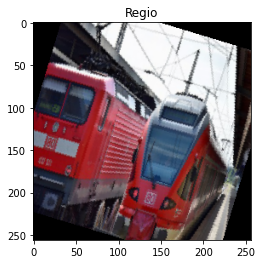

In [ ]:
#Display example train image
img,label = trainset[0]
show_images(img,Config.class_names[label])              

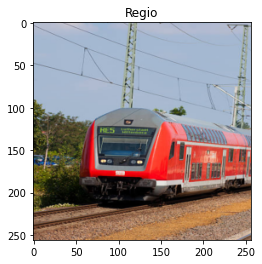

In [ ]:
#Display example test image
img,label = testset[0]
show_images(img,Config.class_names[label])   

In [ ]:
#Putting data into DataLoaders for iteration during training
trainloader = DataLoader(trainset, Config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
print("Trainset size ({}) / batch_size (16) = # of batches: {}".format(len(trainloader.dataset), len(trainloader)))
validloader = DataLoader(validset, Config.batch_size, num_workers=1, pin_memory=True)
print("Validset size ({}) / batch_size (16) = # of batches: {}".format(len(validloader.dataset), len(validloader)))
testloader = DataLoader(testset, Config.batch_size, num_workers=1, pin_memory=True)
print("Testset size ({}) / batch_size (16) = # of batches: {}".format(len(testloader.dataset), len(testloader)))

Trainset size (1151) / batch_size (16) = # of batches: 72
Validset size (143) / batch_size (16) = # of batches: 9
Testset size (143) / batch_size (16) = # of batches: 9


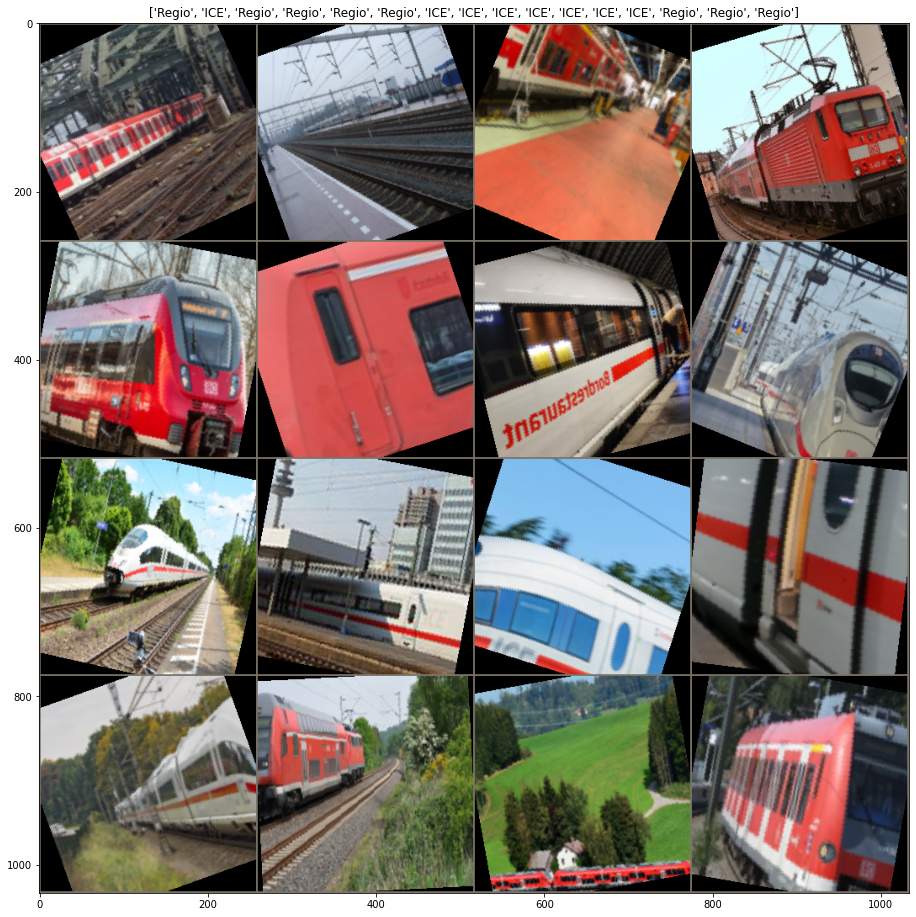

In [ ]:
#Display example batch of images
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_images(out,title = [Config.class_names[x] for x in labels])    

## Setting up Model

In [ ]:
#Load pretrained ResNet-18 model from timm. 
model = timm.create_model('resnet18',pretrained=True)

#Freeze most of pretrained model to train on a smaller number of parameters
for param in model.parameters():
  param.requires_grad = False                     

model.fc = nn.Sequential(                 
    nn.Linear(in_features=512, out_features=256),            
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=256, out_features=2)    
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [ ]:
#Move model to GPU and show summary of model
model.to(device) 
summary(model,  input_size=(3,Config.img_size, Config.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

## Training

In [ ]:
class BahnTrainer():
  def __init__(self, lossfn=None, optimizer=None):
    self.lossfn = lossfn
    self.optimizer = optimizer
  def train(self, model, trainloader):
    loss = 0
    acc = 0
    TP = 0
    FP = 0
    FN = 0
    
    # Iterate across input images
    for images,labels in tqdm(trainloader):
      # loading
      images = images.to(device)
      labels = labels.to(device)

      # forward
      pred = model(images)        
      loss = self.lossfn(pred, labels)

      # backward
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # update metrics
      with torch.no_grad():
        loss += loss.item() * images.size(0)
        acc += accuracy(pred, labels)
        TP += true_positives(pred, labels)
        FP += false_positives(pred, labels)
        FN += false_negatives(pred, labels)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = (2 * precision * recall) / (precision + recall)
    return loss/len(trainloader.dataset), acc/len(trainloader.dataset), precision, recall, F1

  def valid(self, model, validloader):
    loss = 0
    acc = 0
    TP = 0
    FN = 0
    FP = 0
    TN = 0
    for images,labels in tqdm(validloader):
      images = images.to(device)
      labels = labels.to(device)

      pred = model(images)        
      loss = self.lossfn(pred, labels)

      loss += loss.item() * images.size(0)
      acc += accuracy(pred, labels)
      TP += true_positives(pred, labels)
      FN += false_negatives(pred, labels)
      FP += false_positives(pred, labels)
      TN += true_negatives(pred, labels)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = (2 * precision * recall) / (precision + recall)
    confusion_matrix = np.array([[int(TP), int(FN)], [int(FP), int(TN)]])
    return loss/len(validloader.dataset), acc/len(validloader.dataset), precision, recall, F1, confusion_matrix
  
  def fit(self, model, trainloader, validloader, epochs):
    min_valid_loss = np.Inf

    # iterate across training epochs
    for i in range(epochs):
      model.train()
      train_loss, train_acc, train_precision, train_recall, train_F1 = self.train(model, trainloader)

      model.eval()
      valid_loss, valid_acc, valid_precision, valid_recall, valid_F1, _ = self.valid(model, validloader)

      if valid_loss <= min_valid_loss:
        print("Valid_loss decreased {} -> {}".format(min_valid_loss, valid_loss))
        min_valid_loss = valid_loss

      print("Epoch {}: Train Loss: {:.6f}, Train Acc: {:.6f}, Train Precision: {:.6f}, Train Recall: {:.6f}, Train F1 Score: {:.6f}".format(i + 1, train_loss, train_acc, train_precision, train_recall, train_F1))
      print("Epoch {}: Valid Loss: {:.6f}, Valid Acc: {:.6f}, Valid Precision: {:.6f}, Valid Recall: {:.6f}, Valid F1 Score: {:.6f}".format(i + 1, valid_loss, valid_acc, valid_precision, valid_recall, valid_F1))

In [ ]:
if Config.training:
  lossfn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)

  trainer = BahnTrainer(lossfn, optimizer)
  trainer.fit(model, trainloader, validloader, Config.epochs)         

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased inf -> 0.04569124057888985
Epoch 1: Train Loss: 0.006946, Train Acc: 0.715030, Train Precision: 0.693237, Train Recall: 0.885802, Train F1 Score: 0.777778
Epoch 1: Valid Loss: 0.045691, Valid Acc: 0.937063, Valid Precision: 0.941860, Valid Recall: 0.952941, Valid F1 Score: 0.947368


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.04569124057888985 -> 0.029519498348236084
Epoch 2: Train Loss: 0.004569, Train Acc: 0.884448, Train Precision: 0.872648, Train Recall: 0.930556, Train F1 Score: 0.900672
Epoch 2: Valid Loss: 0.029519, Valid Acc: 0.944056, Valid Precision: 0.952941, Valid Recall: 0.952941, Valid F1 Score: 0.952941


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.029519498348236084 -> 0.018451830372214317
Epoch 3: Train Loss: 0.004796, Train Acc: 0.908775, Train Precision: 0.901034, Train Recall: 0.941358, Train F1 Score: 0.920755
Epoch 3: Valid Loss: 0.018452, Valid Acc: 0.909091, Valid Precision: 0.867347, Valid Recall: 1.000000, Valid F1 Score: 0.928962


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.018451830372214317 -> 0.013237454928457737
Epoch 4: Train Loss: 0.002840, Train Acc: 0.911381, Train Precision: 0.909910, Train Recall: 0.935185, Train F1 Score: 0.922374
Epoch 4: Valid Loss: 0.013237, Valid Acc: 0.937063, Valid Precision: 0.913043, Valid Recall: 0.988235, Valid F1 Score: 0.949153


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.013237454928457737 -> 0.011916461400687695
Epoch 5: Train Loss: 0.001803, Train Acc: 0.920070, Train Precision: 0.919940, Train Recall: 0.939815, Train F1 Score: 0.929771
Epoch 5: Valid Loss: 0.011916, Valid Acc: 0.923077, Valid Precision: 0.885417, Valid Recall: 1.000000, Valid F1 Score: 0.939227


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.011916461400687695 -> 0.009977972134947777
Epoch 6: Train Loss: 0.013645, Train Acc: 0.911381, Train Precision: 0.895652, Train Recall: 0.953704, Train F1 Score: 0.923767
Epoch 6: Valid Loss: 0.009978, Valid Acc: 0.923077, Valid Precision: 0.885417, Valid Recall: 1.000000, Valid F1 Score: 0.939227


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.009977972134947777 -> 0.009294427931308746
Epoch 7: Train Loss: 0.001919, Train Acc: 0.926151, Train Precision: 0.924585, Train Recall: 0.945988, Train F1 Score: 0.935164
Epoch 7: Valid Loss: 0.009294, Valid Acc: 0.965035, Valid Precision: 0.954545, Valid Recall: 0.988235, Valid F1 Score: 0.971098


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.009294427931308746 -> 0.007440316956490278
Epoch 8: Train Loss: 0.005166, Train Acc: 0.910513, Train Precision: 0.900147, Train Recall: 0.945988, Train F1 Score: 0.922498
Epoch 8: Valid Loss: 0.007440, Valid Acc: 0.958042, Valid Precision: 0.934066, Valid Recall: 1.000000, Valid F1 Score: 0.965909


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.007440316956490278 -> 0.00627556350082159
Epoch 9: Train Loss: 0.002489, Train Acc: 0.934839, Train Precision: 0.941448, Train Recall: 0.942901, Train F1 Score: 0.942174
Epoch 9: Valid Loss: 0.006276, Valid Acc: 0.958042, Valid Precision: 0.934066, Valid Recall: 1.000000, Valid F1 Score: 0.965909


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.002267, Train Acc: 0.937446, Train Precision: 0.929851, Train Recall: 0.961420, Train F1 Score: 0.945372
Epoch 10: Valid Loss: 0.008702, Valid Acc: 0.979021, Valid Precision: 0.976744, Valid Recall: 0.988235, Valid F1 Score: 0.982456


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.00627556350082159 -> 0.006094364915043116
Epoch 11: Train Loss: 0.002361, Train Acc: 0.932233, Train Precision: 0.925373, Train Recall: 0.956790, Train F1 Score: 0.940819
Epoch 11: Valid Loss: 0.006094, Valid Acc: 0.986014, Valid Precision: 0.977012, Valid Recall: 1.000000, Valid F1 Score: 0.988372


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.000649, Train Acc: 0.931364, Train Precision: 0.933029, Train Recall: 0.945988, Train F1 Score: 0.939464
Epoch 12: Valid Loss: 0.007534, Valid Acc: 0.979021, Valid Precision: 0.976744, Valid Recall: 0.988235, Valid F1 Score: 0.982456


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.006521, Train Acc: 0.937446, Train Precision: 0.931138, Train Recall: 0.959877, Train F1 Score: 0.945289
Epoch 13: Valid Loss: 0.010171, Valid Acc: 0.986014, Valid Precision: 1.000000, Valid Recall: 0.976471, Valid F1 Score: 0.988095


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.006094364915043116 -> 0.0038686844054609537
Epoch 14: Train Loss: 0.000785, Train Acc: 0.937446, Train Precision: 0.937690, Train Recall: 0.952160, Train F1 Score: 0.944870
Epoch 14: Valid Loss: 0.003869, Valid Acc: 0.958042, Valid Precision: 0.934066, Valid Recall: 1.000000, Valid F1 Score: 0.965909


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.002629, Train Acc: 0.921807, Train Precision: 0.920181, Train Recall: 0.942901, Train F1 Score: 0.931403
Epoch 15: Valid Loss: 0.004329, Valid Acc: 0.965035, Valid Precision: 0.944444, Valid Recall: 1.000000, Valid F1 Score: 0.971429


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.004358, Train Acc: 0.940921, Train Precision: 0.935435, Train Recall: 0.961420, Train F1 Score: 0.948250
Epoch 16: Valid Loss: 0.004359, Valid Acc: 0.986014, Valid Precision: 0.977012, Valid Recall: 1.000000, Valid F1 Score: 0.988372


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Valid_loss decreased 0.0038686844054609537 -> 0.003576378570869565
Epoch 17: Train Loss: 0.002871, Train Acc: 0.938315, Train Precision: 0.933835, Train Recall: 0.958333, Train F1 Score: 0.945925
Epoch 17: Valid Loss: 0.003576, Valid Acc: 0.972028, Valid Precision: 0.955056, Valid Recall: 1.000000, Valid F1 Score: 0.977012


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.005993, Train Acc: 0.923545, Train Precision: 0.922961, Train Recall: 0.942901, Train F1 Score: 0.932824
Epoch 18: Valid Loss: 0.008509, Valid Acc: 0.986014, Valid Precision: 1.000000, Valid Recall: 0.976471, Valid F1 Score: 0.988095


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.000762, Train Acc: 0.933971, Train Precision: 0.929429, Train Recall: 0.955247, Train F1 Score: 0.942161
Epoch 19: Valid Loss: 0.007711, Valid Acc: 0.993007, Valid Precision: 1.000000, Valid Recall: 0.988235, Valid F1 Score: 0.994083


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.001757, Train Acc: 0.930495, Train Precision: 0.931611, Train Recall: 0.945988, Train F1 Score: 0.938744
Epoch 20: Valid Loss: 0.005784, Valid Acc: 1.000000, Valid Precision: 1.000000, Valid Recall: 1.000000, Valid F1 Score: 1.000000


  0%|          | 0/9 [00:00<?, ?it/s]

Test Loss: 0.005038650240749121
Test Acc: 0.9790209531784058
Test Precision: 1.0
Test Recall: 0.9659090638160706
Test F1 Score: 0.9826589822769165
Test Confusion Matrix:


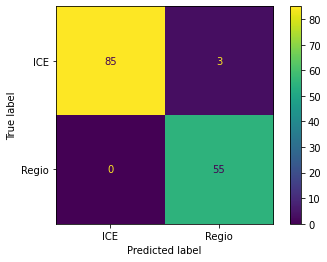

In [ ]:
if Config.training:
  model.eval()

  test_loss, test_acc, test_precision, test_recall, test_F1, test_confusion_matrix = trainer.valid(model, testloader)
                                                                                
  print("Test Loss: {}".format(test_loss))                                  
  print("Test Acc: {}".format(test_acc))       
  print("Test Precision: {}".format(test_precision))
  print("Test Recall: {}".format(test_recall))
  print("Test F1 Score: {}".format(test_F1))
  print("Test Confusion Matrix:")
  cm_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=Config.class_names)
  cm_display.plot()
  plt.show()
  torch.save(model.state_dict(), Config.model_save_path)                      

### Loading Previous Model

In [ ]:
#Load previously trained model and showing performance on test data
if not Config.training:
  model.load_state_dict(torch.load(Config.model_save_path,map_location=device))                    
  model.eval()

  lossfn = nn.CrossEntropyLoss()

  trainer = BahnTrainer(lossfn=lossfn)
  test_loss, test_acc, test_precision, test_recall, test_F1, test_confusion_matrix = trainer.valid(model, testloader)
                                                                                
  print("Test Loss: {}".format(test_loss))                                  
  print("Test Acc: {}".format(test_acc))       
  print("Test Precision: {}".format(test_precision))
  print("Test Recall: {}".format(test_recall))
  print("Test F1 Score: {}".format(test_F1))
  print("Test Confusion Matrix:")
  cm_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix, display_labels=Config.class_names)
  cm_display.plot()
  plt.show()                               

## Example Classifications

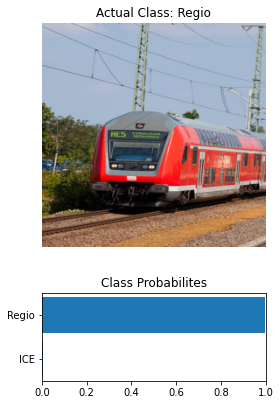

In [ ]:
#Show example prediction
image,label = testset[0]

predictions = model(image.to(device).unsqueeze(0))
predictions = F.softmax(predictions,dim = 1)

display_classif(image,predictions,label)

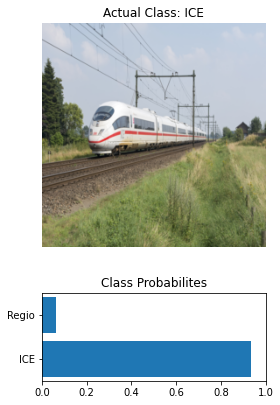

In [ ]:
#Show example prediction
image,label = testset[50]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

display_classif(image,ps,label)